# Automatic Fraud Detection

In [42]:
import pandas as pd 
import numpy as np 
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt

## ETL

In [43]:
df = pd.read_csv("../data/creditcard.csv")
#df = df.head(100000)

In [44]:
print(f"There are {df.isnull().sum().sum()} missing values in the dataset.")

There are 0 missing values in the dataset.


In [45]:
fraud_prop = (df["Class"] == 1).sum()/len(df)
print(f"Fraud in the dataset : {fraud_prop}.")
print(f"No fraud in the dataset : {1-fraud_prop}.")

if fraud_prop < 0.4: 
    print("The dataset is imbalanced.")
else: 
    print("The dataset is balanced.")

Fraud in the dataset : 0.001727485630620034.
No fraud in the dataset : 0.9982725143693799.
The dataset is imbalanced.


<Axes: xlabel='Class', ylabel='count'>

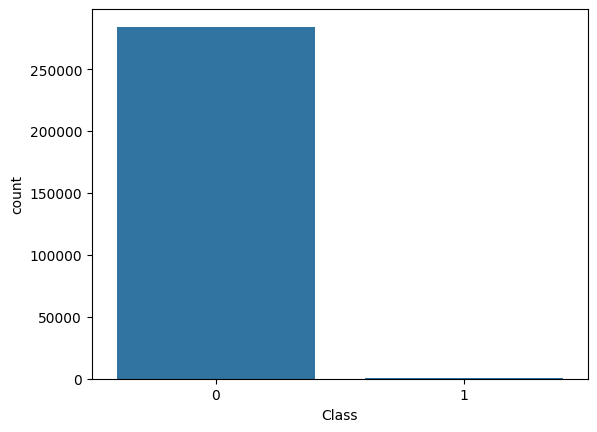

In [46]:
sns.countplot(data=df, x="Class")

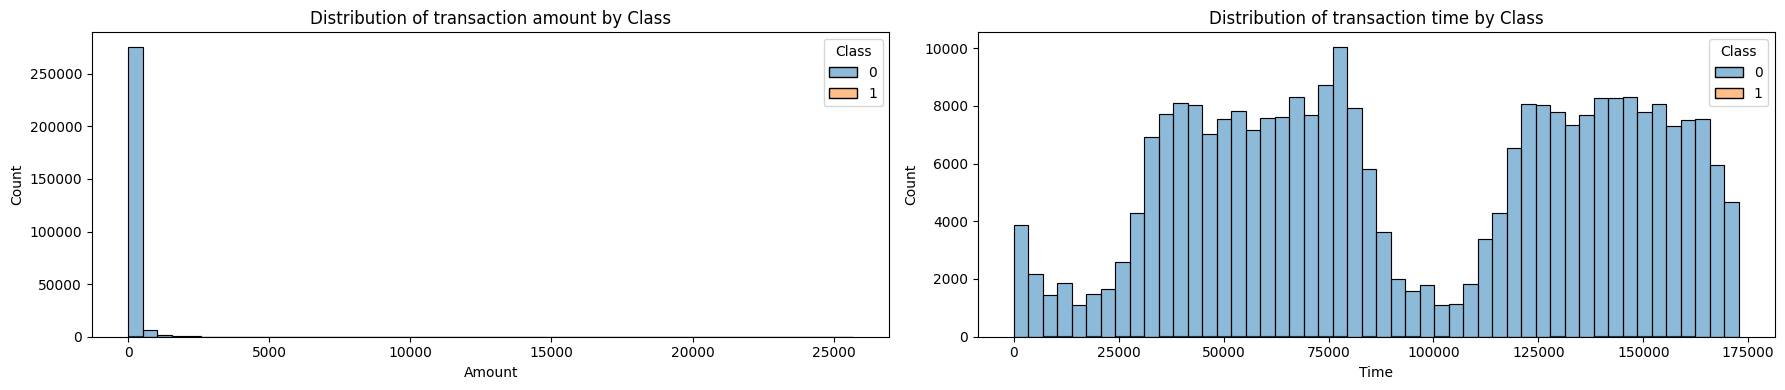

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(
    data=df,
    x="Amount",
    hue="Class",
    bins=50,
    kde=False,
    ax=ax[0]
)
ax[0].set_title("Distribution of transaction amount by Class")

sns.histplot(
    data=df,
    x="Time",
    hue="Class",
    bins=50,
    kde=False,
    ax=ax[1]
)
ax[1].set_title("Distribution of transaction time by Class")

plt.tight_layout()
plt.show()

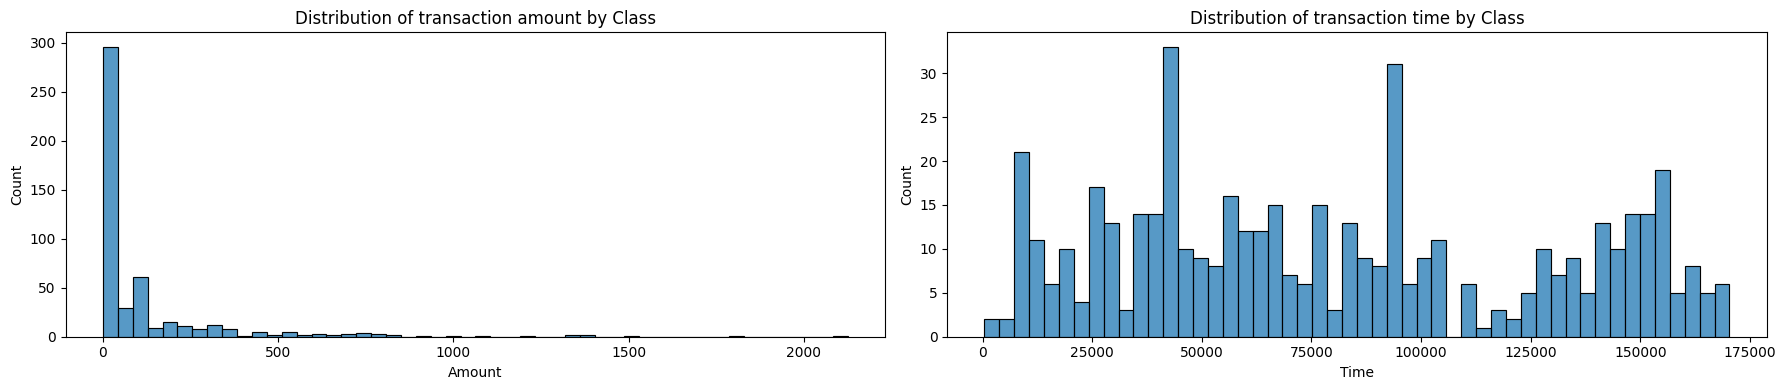

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(
    data=df[df["Class"] == 1],
    x="Amount",
    bins=50,
    kde=False,
    ax=ax[0]
)
ax[0].set_title("Distribution of transaction amount by Class")

sns.histplot(
    data=df[df["Class"] == 1],
    x="Time",
    bins=50,
    kde=False,
    ax=ax[1]
)
ax[1].set_title("Distribution of transaction time by Class")

plt.tight_layout()
plt.show()

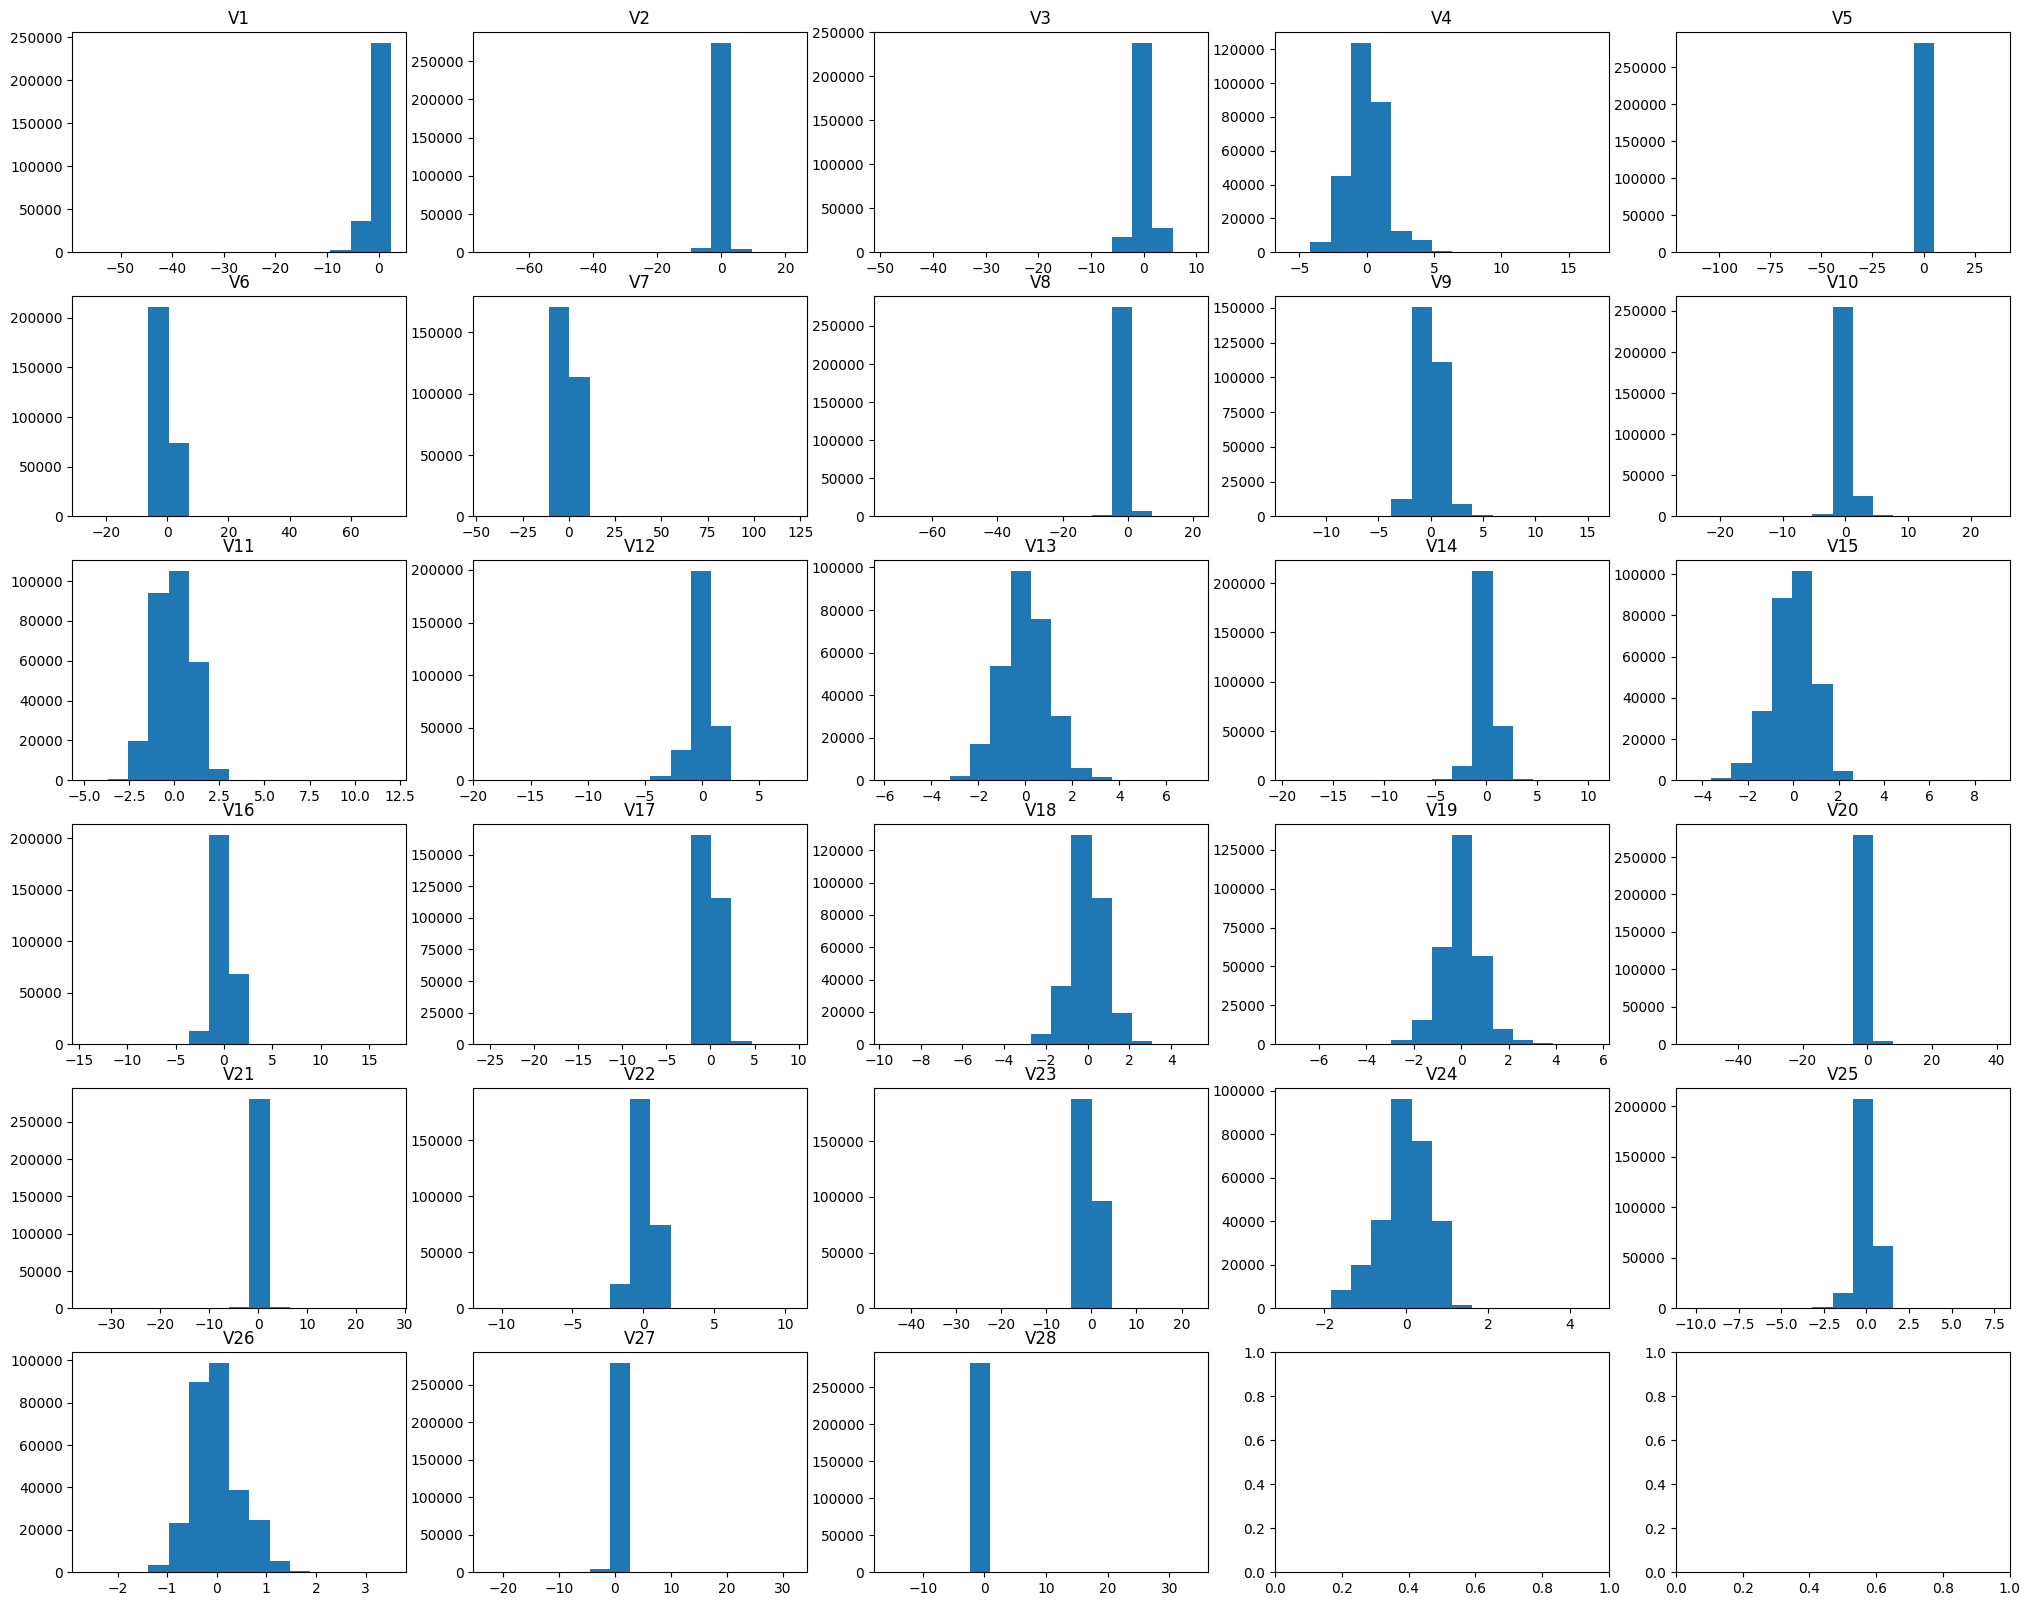

In [49]:
fig, ax = plt.subplots(6,5, figsize=(25, 20))
ax = ax.flatten()

for i in range(28):
    ax[i].hist(df[f"V{i+1}"], bins=15)
    ax[i].set_title(f"V{i+1}")

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["Amount_scaled"] = scaler.fit_transform(df[["Amount"]])
df["Time_scaled"] = scaler.fit_transform(df[["Time"]])

df = df.drop(["Amount", "Time"], axis=1)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled,Time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


## PCA

In [51]:
def temporal_split(df, split_ratio=0.7):
    split_time = df["Time_scaled"].quantile(split_ratio)

    train = df[df["Time_scaled"] <= split_time]
    test  = df[df["Time_scaled"] > split_time]

    return train, test

In [52]:
from sklearn.model_selection import train_test_split

#df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df["Class"])
df_train, df_test = temporal_split(df)

y = df_train.pop("Class")
X = df_train

print(f"Original train dataset shape: {y.value_counts()}")

y_invisible = df_test.pop("Class")
X_invisible = df_test

print(f"Invisible test dataset shape: {y_invisible.value_counts()}")


Original train dataset shape: Class
0    198984
1       384
Name: count, dtype: int64
Invisible test dataset shape: Class
0    85331
1      108
Name: count, dtype: int64


[0.11634851 0.09533533]


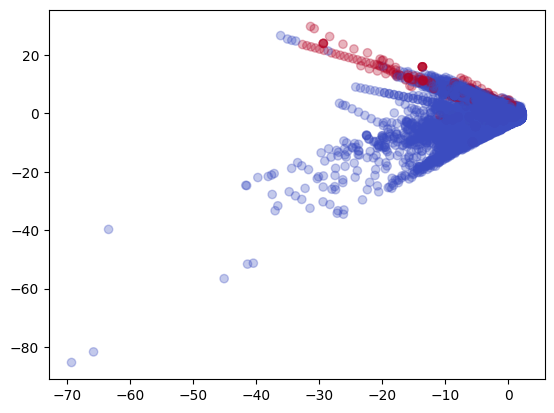

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.3)

## Modélisation

In [54]:
from sklearn.model_selection import StratifiedKFold



kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[     0      1      2 ... 199365 199366 199367]
  Test:  index=[    12     13     14 ... 199332 199340 199351]
Fold 1:
  Train: index=[     0      2      3 ... 199364 199365 199366]
  Test:  index=[     1      4      5 ... 199355 199360 199367]
Fold 2:
  Train: index=[     0      1      2 ... 199364 199366 199367]
  Test:  index=[     7     10     17 ... 199361 199362 199365]
Fold 3:
  Train: index=[     0      1      4 ... 199365 199366 199367]
  Test:  index=[     2      3     19 ... 199349 199359 199363]
Fold 4:
  Train: index=[     1      2      3 ... 199363 199365 199367]
  Test:  index=[     0      6      8 ... 199357 199364 199366]


In [55]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
}
for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
    print(f"Fold {i}:")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = IsolationForest(random_state=0)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1)
    #print(y_pred)

    metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
    metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))

df_metrics.loc[0] = [
    "IsolationForest",
    np.mean(metrics["accuracy"]),
    np.mean(metrics["balanced accuracy"]),
    np.mean(metrics["recall"]),
    np.mean(metrics["precision"])
]

df_metrics

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,IsolationForest,0.961564,0.896322,0.830827,0.040608


In [56]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score
from xgboost import XGBClassifier

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

models = {
    #"RandomForestClassifier": RandomForestClassifier(), 
    #"GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=0),
    "XGBClassifier": XGBClassifier(n_estimators=100),
    #"AdaBoostClassifier": AdaBoostClassifier()
}

for model_name in models: 
    print(f"Processing {model_name}...")
    metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
    }
    for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
        print(f"Fold {i}:")
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = models[model_name]
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
        metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))
    
    df_metrics.loc[len(df_metrics)] = [
        model_name,
        np.mean(metrics["accuracy"]),
        np.mean(metrics["balanced accuracy"]),
        np.mean(metrics["recall"]),
        np.mean(metrics["precision"])
    ]

df_metrics

Processing XGBClassifier...
Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,XGBClassifier,0.998134,0.743528,0.487936,0.557313


## OVERSAMPLING : SMOTE 

In [57]:
import imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Original dataset shape: {y.value_counts()}")
print(f"Resampled dataset shape: {y_resampled.value_counts()}")

Original dataset shape: Class
0    198984
1       384
Name: count, dtype: int64
Resampled dataset shape: Class
0    198984
1    198984
Name: count, dtype: int64


[0.70290899 0.09873321]


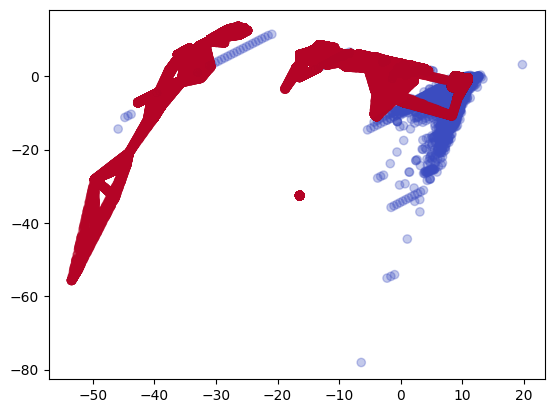

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)
print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_resampled, cmap='coolwarm', alpha=0.3)

In [59]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
}
for i, (train_index, test_index) in enumerate(kfold.split(X_resampled,y_resampled)):
    print(f"Fold {i}:")
    
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    model = IsolationForest(random_state=0)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1)
    #print(y_pred)

    metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
    metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))

df_metrics.loc[0] = [
    "IsolationForest",
    np.mean(metrics["accuracy"]),
    np.mean(metrics["balanced accuracy"]),
    np.mean(metrics["recall"]),
    np.mean(metrics["precision"])
]

df_metrics

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,IsolationForest,0.640984,0.640984,0.292496,0.965114


In [60]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score
from xgboost import XGBClassifier

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

models = {
    #"RandomForestClassifier": RandomForestClassifier(), 
    #"GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=0),
    "XGBClassifier": XGBClassifier(n_estimators=100),
    #"AdaBoostClassifier": AdaBoostClassifier()
}

for model_name in models: 
    print(f"Processing {model_name}...")
    metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
    }
    for i, (train_index, test_index) in enumerate(kfold.split(X_resampled,y_resampled)):
        print(f"Fold {i}:")
        
        X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

        model = models[model_name]
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
        metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))
    
    df_metrics.loc[len(df_metrics)] = [
        model_name,
        np.mean(metrics["accuracy"]),
        np.mean(metrics["balanced accuracy"]),
        np.mean(metrics["recall"]),
        np.mean(metrics["precision"])
    ]

df_metrics

Processing XGBClassifier...
Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,XGBClassifier,0.999764,0.999764,1.0,0.999528


## UNDERSAMPLING

In [61]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"Original dataset shape: {y.value_counts()}")
print(f"Resampled dataset shape: {y_resampled.value_counts()}")

Original dataset shape: Class
0    198984
1       384
Name: count, dtype: int64
Resampled dataset shape: Class
0    384
1    384
Name: count, dtype: int64


[0.6903052  0.10386468]


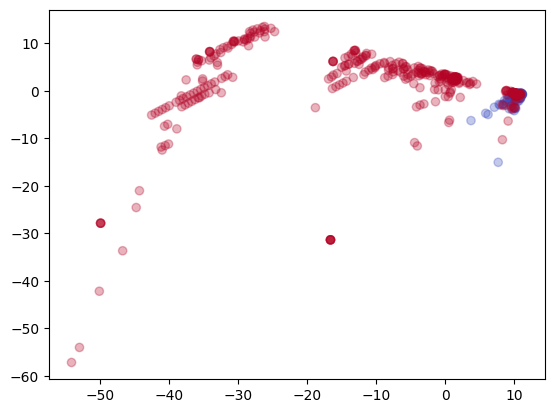

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)
print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_resampled, cmap='coolwarm', alpha=0.3)

In [63]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
}
for i, (train_index, test_index) in enumerate(kfold.split(X_resampled,y_resampled)):
    print(f"Fold {i}:")
    
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    model = IsolationForest(random_state=0)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1)
    #print(y_pred)

    metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
    metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))

df_metrics.loc[0] = [
    "IsolationForest",
    np.mean(metrics["accuracy"]),
    np.mean(metrics["balanced accuracy"]),
    np.mean(metrics["recall"]),
    np.mean(metrics["precision"])
]

df_metrics

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,IsolationForest,0.634038,0.634057,0.270711,0.988889


In [64]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score
from xgboost import XGBClassifier

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

models = {
    #"RandomForestClassifier": RandomForestClassifier(), 
    #"GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=0),
    "XGBClassifier": XGBClassifier(n_estimators=100),
    #"AdaBoostClassifier": AdaBoostClassifier()
}

for model_name in models: 
    print(f"Processing {model_name}...")
    metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
    }
    for i, (train_index, test_index) in enumerate(kfold.split(X_resampled,y_resampled)):
        print(f"Fold {i}:")
        
        X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

        model = models[model_name]
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
        metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))
    
    df_metrics.loc[len(df_metrics)] = [
        model_name,
        np.mean(metrics["accuracy"]),
        np.mean(metrics["balanced accuracy"]),
        np.mean(metrics["recall"]),
        np.mean(metrics["precision"])
    ]

df_metrics

Processing XGBClassifier...
Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,XGBClassifier,0.940149,0.94014,0.921941,0.956781


## UNDER AND OVER SAMPLING

In [65]:
df_class_0 = df[df["Class"] == 0]
df_class_1 = df[df["Class"] == 1]

# Réduction de 50 % de la classe 0
df_class_0_reduit = df_class_0.sample(frac=0.3, random_state=42)

# Recombiner le dataset
df_reduit = pd.concat([df_class_0_reduit, df_class_1], axis=0)

# Mélanger les lignes
df_reduit = df_reduit.sample(frac=1, random_state=42).reset_index(drop=True)

y_reduit = df_reduit.pop("Class")
X_reduit = df_reduit

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_reduit, y_reduit)

print(f"Original dataset shape: {y_reduit.value_counts()}")
print(f"Resampled dataset shape: {y_resampled.value_counts()}")

Original dataset shape: Class
0    85294
1      492
Name: count, dtype: int64
Resampled dataset shape: Class
0    85294
1    85294
Name: count, dtype: int64


[0.68869765 0.09521079]


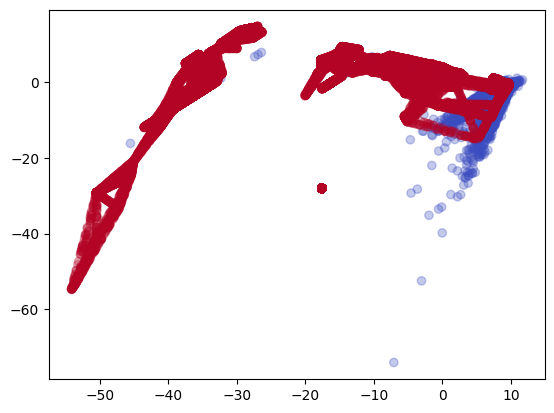

In [66]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)
print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_resampled, cmap='coolwarm', alpha=0.3)

In [67]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
}
for i, (train_index, test_index) in enumerate(kfold.split(X_resampled,y_resampled)):
    print(f"Fold {i}:")
    
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    model = IsolationForest(random_state=0)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1)
    #print(y_pred)

    metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
    metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
    metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))

df_metrics.loc[0] = [
    "IsolationForest",
    np.mean(metrics["accuracy"]),
    np.mean(metrics["balanced accuracy"]),
    np.mean(metrics["recall"]),
    np.mean(metrics["precision"])
]

df_metrics

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,IsolationForest,0.613144,0.613144,0.236347,0.959183


In [68]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score
from xgboost import XGBClassifier

df_metrics = pd.DataFrame(columns=["model", "accuracy", "balanced accuracy", "recall", "precision"])

models = {
    #"RandomForestClassifier": RandomForestClassifier(), 
    #"GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=0),
    "XGBClassifier": XGBClassifier(n_estimators=100),
    #"AdaBoostClassifier": AdaBoostClassifier()
}

for model_name in models: 
    print(f"Processing {model_name}...")
    metrics = {
    "accuracy": [],
    "balanced accuracy": [],
    "recall": [],
    "precision": []
    }
    for i, (train_index, test_index) in enumerate(kfold.split(X_resampled,y_resampled)):
        print(f"Fold {i}:")
        
        X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

        model = models[model_name]
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
    
        metrics["accuracy"].append(accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["balanced accuracy"].append(balanced_accuracy_score(y_true=y_test, y_pred=y_pred))
        metrics["recall"].append(recall_score(y_true=y_test, y_pred=y_pred))
        metrics["precision"].append(precision_score(y_true=y_test, y_pred=y_pred))
    
    df_metrics.loc[len(df_metrics)] = [
        model_name,
        np.mean(metrics["accuracy"]),
        np.mean(metrics["balanced accuracy"]),
        np.mean(metrics["recall"]),
        np.mean(metrics["precision"])
    ]

df_metrics

Processing XGBClassifier...
Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


,model,accuracy,balanced accuracy,recall,precision
0,XGBClassifier,0.999361,0.999361,0.999988,0.998735


## Test on the invisible dataset 

In [69]:
from sklearn.metrics import classification_report

y_invisible_pred = model.predict(X_invisible)
print(classification_report(y_invisible_pred, y_invisible))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85253
           1       1.00      0.58      0.73       186

    accuracy                           1.00     85439
   macro avg       1.00      0.79      0.87     85439
weighted avg       1.00      1.00      1.00     85439

